In [101]:
# Paths
import os
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

os.chdir('../..')
from pcmf import pcmf_full, path_plot, plot_ordercolor, plot_cluster_assignments, PCMF_predict_clusters
from p3ca import cluster_metrics, calculate_scores_nonpath
import numpy as np
%load_ext autoreload
from sklearn.cluster import KMeans


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Functions
def run_fitPCMF_experiment_consensusICML2023(savedir='/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/',dataset='MNIST', problem_rank=100, rho=2.0, gc=1.0, neighbors=40, admm_iters=2, penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,10))[::-1]),axis=0), skip=1, labels_keep=[0,1,2,3,4,5], data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/',randomize=False):
    from pcmf import pcmf_full_consensus_2023 as pcmf_consensus
    import time
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    # LOAD DATA
    batch_size = 50
    if dataset == 'MNIST':
        save_path=savedir+'MNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_MNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'FashionMNIST':
        save_path=savedir+'FashionMNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_FashionMNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'GBMBreastLung':
        save_path=savedir+'GBMBreastLung_'+'skip'+str(skip)+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters  = load_GBMBreastLung(data_path=data_path, plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'Synthetic':
        save_path=savedir+'Synthetic100000_'+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, num_clusters, u_true, v_true = load_syntheticDataConsensus(n=100000, n_test=10000, p=1000, m=25000, m_test=2500, plot=False, randomize=randomize)
    else:
        print('Dataset not implemented:',dataset)
        return
    
    print('Problem rank',problem_rank)
    print('Save path is:',save_path+'.npz')

    # STANDARDIZE DATA
    scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
    X_in = scaler.transform(X_in)
    normalizer = Normalizer().fit(X_in)
    X_in = normalizer.transform(X_in)
    scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
    X_in = scaler2.transform(X_in)

    X_in_test = scaler.transform(X_in_test)
    X_in_test = normalizer.transform(X_in_test)
    X_in_test = scaler2.transform(X_in_test)

    # Fit PCMF
    tic=time.time()
    A_list, U_list, s_list, V_list = pcmf_consensus(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
    toc=time.time() - tic
    
    A = A_list
    U = U_list
    S = s_list
    V = V_list

    X_compA = []
    X_compB = []
    UV = []
    USV = []
    for p in range(len(penalty_list)):
        x_pcmf = U[p]*S[p][:,0] # should the 0 be here??
        x_pcmf2 = (X_in[:,:] @ V[p].T) 
        X_compA.append(np.array(x_pcmf))
        X_compB.append(np.array(x_pcmf2))
        UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
        USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

    X_compA=np.asarray(X_compA)
    X_compB=np.asarray(X_compB)
    
    # SAVE DATASET    
    np.savez(save_path+".npz",  A=A, U=U, S=S, V=V, UV=UV, USV=USV, X_compA=X_compA, X_compB=X_compB, X_in=X_in, true_clusters_in=true_clusters_in, X_in_test=X_in_test, true_clusters_in_test=true_clusters_in_test, true_clusters_labels=true_clusters_labels, num_clusters=num_clusters, u_true=u_true, v_true=v_true, split_size=batch_size, runtime=toc, penalty_list=np.asarray(penalty_list), rho=rho, admm_iters=admm_iters, gc=gc, neighbors=neighbors) 
#     generate_plots_synthetic(A, U, V, S, split_size, penalty_list, true_clusters_all, save_path+".pdf")
    del A, U, S, V, UV, USV, X_compA, X_compB, X_in, true_clusters_in, toc
    
    return save_path+".npz"

from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog, linear_sum_assignment as linear_assignment

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

# Fashion MNIST
def load_FashionMNIST(labels_keep=[0,3,5], plot=False, skip=1, batch_size=50, randomize=False):
    import numpy as np
    from keras.datasets import fashion_mnist
    from matplotlib import pyplot
    import pandas as pd

    print('Loading Fashion MNIST')
    # Loading
    (train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

    # Shape of dataset
    print('X_train: ' + str(train_X.shape))
    print('Y_train: ' + str(train_y.shape))
    print('X_test:  '  + str(test_X.shape))
    print('Y_test:  '  + str(test_y.shape))

    if plot is True:
        # Plotting
        from matplotlib import pyplot
        for i in range(9):  
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
            pyplot.show()

    # Select data corresponding to a subset of the latbels
    inds = []
    inds_test = []
    for ind in labels_keep:
        inds.append(np.where(train_y==ind)[0])
        inds_test.append(np.where(test_y==ind)[0])
        
    inds = np.hstack(inds)
    inds_test = np.hstack(inds_test)

    # Select training set
    X_in = train_X[inds,:].reshape((train_X[inds,:].shape[0],28*28))
    true_clusters_in = pd.factorize(train_y[inds])[0]
    
    # Randomize training setorder
    if randomize is True:
        print('Randomizing order seed 42')
        idxs = np.random.RandomState(seed=42).permutation(X_in.shape[0])
        X_in2 = X_in[idxs,:]
        true_clusters_in2 = true_clusters_in[idxs]
        
        X_in = X_in2
        true_clusters_in = true_clusters_in2
        del X_in2, true_clusters_in2
    
    # subset evenly sampled across remaining n_X using skip
    X_in = X_in[::skip]
    true_clusters_in = true_clusters_in[::skip]
    true_clusters_labels = pd.factorize(train_y[inds])[1]
    num_clusters = len(np.unique(true_clusters_in))
    print('X_train',X_in.shape, 'Y_train', true_clusters_in.shape)    
    print('Class labels',true_clusters_labels,'indexed as',np.unique(true_clusters_in))
    
    # Select test set
    X_in_test = test_X[inds_test,:].reshape((test_X[inds_test,:].shape[0],28*28))
    true_clusters_in_test = pd.factorize(test_y[inds_test])[0]
    print('X_test',X_in.shape, 'Y_test', true_clusters_in.shape)

    # Subset training set to be a multiple of the batch size, batch_size
    n_X = X_in.shape[0]
    mod = n_X % batch_size
    n_X_new = n_X - mod
    print('n_X', n_X, 'batch size', batch_size, 'modulo', mod, 'is now', 'n_X', n_X_new, 'batch size', batch_size, 'modulo', (n_X - mod) % batch_size)

    X_in = X_in[0:n_X_new,:]
    true_clusters_in = true_clusters_in[0:n_X_new]

    print('Training set is now:', X_in.shape, true_clusters_in.shape)
    
    return X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters


    
    


In [6]:
# Load Fashion MNIST
X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_FashionMNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=1, batch_size=50)




Loading Fashion MNIST
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
X_train (36000, 784) Y_train (36000,)
Class labels [0 1 2 3 4 5] indexed as [0 1 2 3 4 5]
X_test (36000, 784) Y_test (36000,)
n_X 36000 batch size 50 modulo 0 is now n_X 36000 batch size 50 modulo 0
Training set is now: (36000, 784) (36000,)


In [44]:
# savedir = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/'
# data_path = '/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/'
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,5))[::-1]),axis=0)
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,5))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,30))[::-1]),axis=0)
randomize = False
rho = 2.0
gc = 1.0
neighbors = 40
admm_iters = 2 #15#2#15
skip = 1#20
labels_keep = [0,1,2,3,4,5]


# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,5))[::-1]),axis=0)
# randomize = False
# rho = 0.25
# gc = 0.5
# neighbors = 25
# admm_iters = 25 #15#2#15
# skip = 1#20
# labels_keep = [0,1,2,3,4,5]
# problem_rank = 15
# data_path = run_fitPCMF_experiment_consensusICML2023(dataset='FashionMNIST', problem_rank=problem_rank, rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, randomize=randomize)



Loading Fashion MNIST
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
X_train (36000, 784) Y_train (36000,)
Class labels [0 1 2 3 4 5] indexed as [0 1 2 3 4 5]
X_test (36000, 784) Y_test (36000,)
n_X 36000 batch size 50 modulo 0 is now n_X 36000 batch size 50 modulo 0
Training set is now: (36000, 784) (36000,)
Save path is: /athena/listonlab/store/amb2022/PCMF/results_ICML2023/FashionMNIST_skip1_nclusters6_batchSize_50_pathLength10_gausscoef0.5_neighbors25_admm_iters25_rho0.25.npz
weights: Gaussian neighbors: 25 gauss_coef: 0.5 rho: 0.25
rho1: 0.25 rho2 0.25
Number of batches: 720
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Initialize IDX: 4
Initialize IDX: 5
Initialize IDX: 6
Initialize IDX: 7
Initialize IDX: 8
Initialize IDX: 9
Initialize IDX: 10
Initialize IDX: 11
Initialize IDX: 12
Initialize IDX: 13
Initialize IDX: 14
Initialize IDX: 15
Initialize IDX: 16
Initialize IDX: 17
Initialize IDX: 18
Initialize IDX: 19
Init

Initialize IDX: 392
Initialize IDX: 393
Initialize IDX: 394
Initialize IDX: 395
Initialize IDX: 396
Initialize IDX: 397
Initialize IDX: 398
Initialize IDX: 399
Initialize IDX: 400
Initialize IDX: 401
Initialize IDX: 402
Initialize IDX: 403
Initialize IDX: 404
Initialize IDX: 405
Initialize IDX: 406
Initialize IDX: 407
Initialize IDX: 408
Initialize IDX: 409
Initialize IDX: 410
Initialize IDX: 411
Initialize IDX: 412
Initialize IDX: 413
Initialize IDX: 414
Initialize IDX: 415
Initialize IDX: 416
Initialize IDX: 417
Initialize IDX: 418
Initialize IDX: 419
Initialize IDX: 420
Initialize IDX: 421
Initialize IDX: 422
Initialize IDX: 423
Initialize IDX: 424
Initialize IDX: 425
Initialize IDX: 426
Initialize IDX: 427
Initialize IDX: 428
Initialize IDX: 429
Initialize IDX: 430
Initialize IDX: 431
Initialize IDX: 432
Initialize IDX: 433
Initialize IDX: 434
Initialize IDX: 435
Initialize IDX: 436
Initialize IDX: 437
Initialize IDX: 438
Initialize IDX: 439
Initialize IDX: 440
Initialize IDX: 441


In [51]:
data_path = '/athena/listonlab/store/amb2022/PCMF/results_ICML2023/FashionMNIST_skip1_nclusters6_batchSize_50_pathLength35_gausscoef1.0_neighbors40_admm_iters2_rho2.0.npz'
print(data_path)
results = np.load(data_path, allow_pickle=True)

A = results['A']
U = results['U']
V = results['V']
S = results['S']
UV = results['UV']
USV = results['USV']
X_compA = results['X_compA']
X_compB = results['X_compB']
X_in = results['X_in']
true_clusters_in = results['true_clusters_in']
X_in_test = results['X_in_test']
true_clusters_in_test = results['true_clusters_in_test']
true_clusters_labels = results['true_clusters_labels']
num_clusters = results['num_clusters']
u_true = results['u_true']
v_true = results['v_true']
split_size = results['split_size']
toc = results['runtime']
penalty_list = results['penalty_list']
rho = results['rho']
admm_iters = results['admm_iters']
gc = results['gc']
neighbors = results['neighbors']



/athena/listonlab/store/amb2022/PCMF/results_ICML2023/FashionMNIST_skip1_nclusters6_batchSize_50_pathLength35_gausscoef1.0_neighbors40_admm_iters2_rho2.0.npz


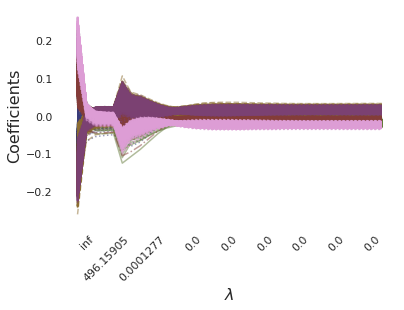

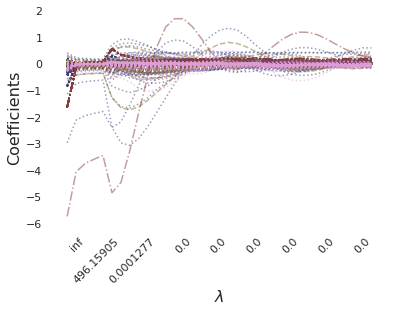

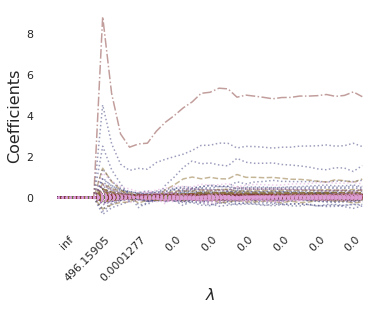

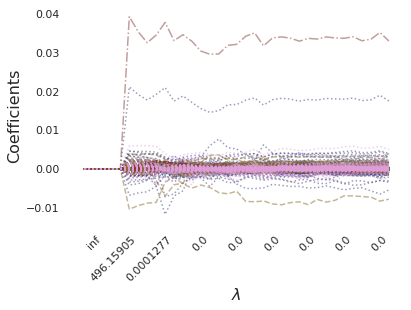

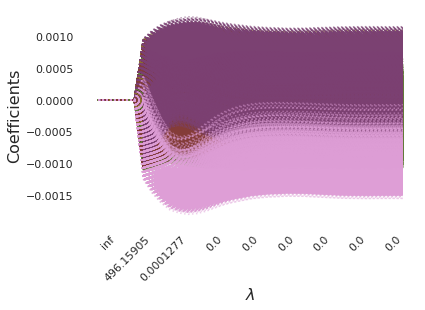

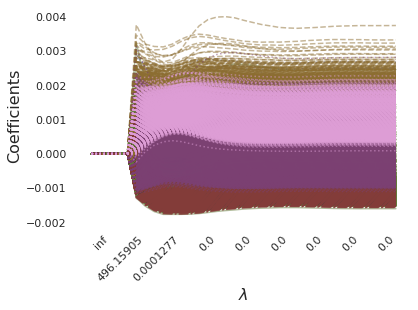

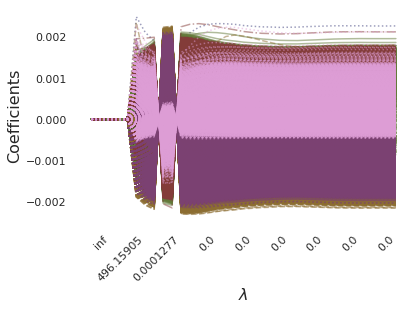

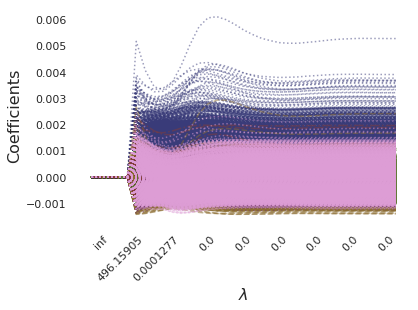

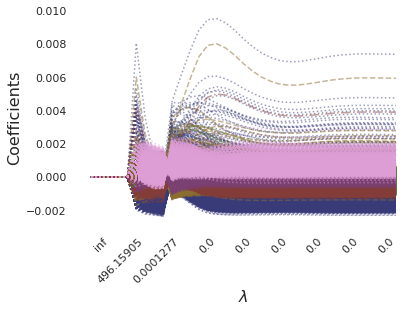

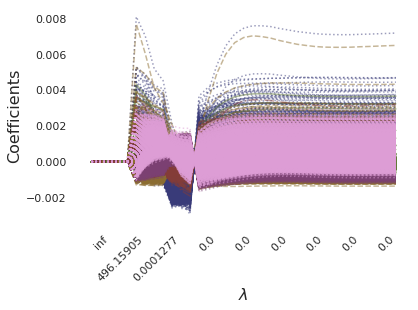

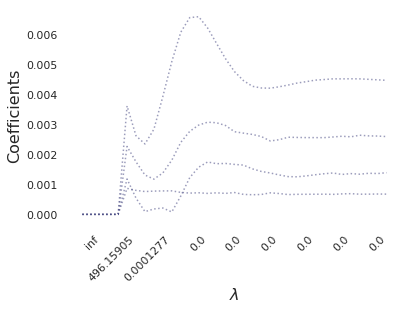

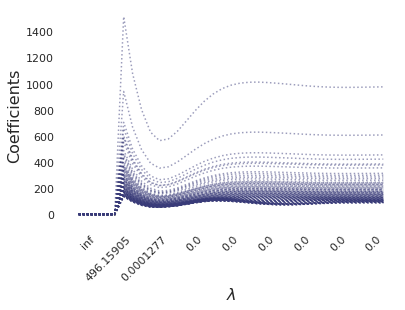

In [52]:
from matplotlib import pyplot as plt
def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set()

    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,len(np.unique(true_clusters)) ))
    else:
        colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[1]))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_facecolor('white')
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
skip=1


path_plot(np.mean(np.asarray(A),axis=2)[:,:,np.newaxis][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(A)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(USV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(UV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip], figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,1:2][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,2:3][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,3:4][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,4:5][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,5:6][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(V)[:,0:4,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(S)[:,:,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in[::skip],figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)



In [54]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]*np.array(S[P]).flatten()@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(A[P])[:,:])
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(X_compB[P])[:,:])
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    import sklearn
    
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(P,sklearn.metrics.adjusted_rand_score(cs,true_clusters_in[0:n_Y]), acc)

if n_Y < 2000:
    # Fit PCMF
    tic=time.time()
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    
from sklearn.decomposition import PCA
tic=time.time()
pca = PCA(n_components=U[0].shape[1])
pca_in = pca.fit_transform(X_in[:,0:n_X])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

k = 100
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
# pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2000:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), toc)



0 0.0 0.16666666666666666
1 0.0 0.16666666666666666
2 0.0 0.16666666666666666
3 0.0 0.16666666666666666
4 0.0 0.16666666666666666
5 0.7845847600728809 0.8981944444444444
6 0.9334671375883491 0.97075
7 0.9839966930507217 0.9932222222222222
8 0.995491744420116 0.9981111111111111
9 0.9978720638154409 0.9991111111111111
10 0.9970108417474274 0.99875
11 0.9954252804161932 0.9980833333333333
12 0.9893932800223426 0.9955277777777778
13 0.9836692254228475 0.9930833333333333
14 0.9715391623169555 0.9878333333333333
15 0.963198759759256 0.9841666666666666
16 0.9551202613431381 0.9805555555555555
17 0.9508945868670263 0.9786666666666667
18 0.9482624379182982 0.9774722222222222
19 0.9496304618218868 0.9781111111111112
20 0.9498301811018002 0.9781944444444445
21 0.9526344526066141 0.9794722222222222
22 0.9532874684602063 0.97975
23 0.9566410863753126 0.9812777777777778
24 0.9565274697387888 0.9812222222222222
25 0.9555660199938242 0.9807777777777777
26 0.9562906521920604 0.9811111111111112
27 0.956

In [ ]:
# %aimport 
from pcmf import PCMF_predict_clusters
for P in range(len(penalty_list)):
    print(P)
    PCMF_predict_clusters(X_in_test, UV[P], V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
    PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)



In [14]:
from numba import jit, prange
from sklearn.neighbors import NearestNeighbors
from scipy import stats

@jit(nopython=False, parallel=True, fastmath=True)
def predict_NN(neighbors, X_in_test, X_in, true_clusters_in, true_clusters_in_test, true_clusters_test_predict):
    true_clusters_test_predict2 = []
    print(X_in_test.shape, true_clusters_in_test.shape, true_clusters_test_predict.shape, X_in.shape, true_clusters_in.shape)
    for i in prange(X_in_test.shape[0]):
        nbrs = NearestNeighbors(n_neighbors=int(neighbors), algorithm='ball_tree').fit(np.vstack((X_in_test[i,:],X_in)))
        _, indices = nbrs.kneighbors(np.vstack((X_in_test[i,:],X_in)))
        NN_train_inds = np.array(indices)[0,:][1:neighbors]-1
        mode, count = stats.mode(true_clusters_in[NN_train_inds])
        cl = int(mode)
        true_clusters_test_predict2.append(cl)
        print(i, cl, true_clusters_test_predict[i], true_clusters_in_test[i])
        
    return np.array(true_clusters_test_predict2)



In [38]:
P = 9
print(X_in[::20].shape)
XV_c, true_clusters_test_predict, XV_test, cluster_acc = PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
# true_clusters_test_predict2 = predict_NN(20, X_in_test[::20], X_in[::5], true_clusters_in[::5], true_clusters_in_test[::20], true_clusters_test_predict[::20])
# true_clusters_test_predict2 = predict_NN(10, XV_test[::20], UV[P][::2]@np.array(V[P]).T, true_clusters_in[::2], true_clusters_in_test[::20], true_clusters_test_predict[::20])
true_clusters_test_predict2 = predict_NN(10, XV_test[::20], X_in[::10]@np.array(V[P]).T, true_clusters_in[::10], true_clusters_in_test[::20], true_clusters_test_predict[::20])

conf_mat_ord = confusion_matrix_ordered(true_clusters_test_predict2, true_clusters_in_test[::20])
np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)


(1800, 784)
Test set cluster accuracy: 0.7558333333333334
(300, 100) (300,) (300,) (3600, 100) (3600,)
0 0 0 0
1 0 0 0
2 0 0 0
3 3 5 0
4 0 0 0
5 0 3 0
6 0 2 0
7 0 0 0
8 3 5 0
9 0 0 0
10 0 0 0
11 0 5 0
12 0 0 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 3 3 0
18 3 3 0
19 0 0 0
20 2 2 0
21 0 5 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 3 0
27 0 0 0
28 0 0 0
29 0 3 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 0 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 2 0
41 0 5 0
42 3 3 0
43 0 5 0
44 0 0 0
45 3 3 0
46 0 0 0
47 0 3 0
48 0 0 0
49 3 3 0
50 1 1 1
51 1 1 1
52 1 1 1
53 3 1 1
54 3 3 1
55 1 1 1
56 0 3 1
57 1 1 1
58 1 1 1
59 1 1 1
60 1 1 1
61 1 1 1
62 3 5 1
63 1 1 1
64 1 1 1
65 1 1 1
66 1 1 1
67 1 1 1
68 1 1 1
69 1 1 1
70 1 1 1
71 1 1 1
72 1 1 1
73 1 1 1
74 1 0 1
75 1 1 1
76 1 3 1
77 3 3 1
78 1 1 1
79 1 3 1
80 1 1 1
81 1 1 1
82 1 1 1
83 1 1 1
84 1 1 1
85 1 1 1
86 1 1 1
87 1 1 1
88 1 1 1
89 1 1 1
90 1 1 1
91 1 1 1
92 3 5 1
93 1 1 1
94 1 1 1
95 0 3 1
96 1 1 1
97 1 1 1
98 3 3 1
99 1 1 1
100 2 2

0.86

In [28]:
print(X_in[::100].shape)

(360, 784)


In [26]:
print(toc)

1447.8828718662262


In [80]:
import os
# os.system('module load py-rpy2-3.0.4-gcc-8.2.0-bycvpkw')
# os.system('module load r-4.0.3-gcc-8.2.0-ydnhx3t')
os.system('spack load r@4.0.2')

Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'


0

In [84]:
os.environ['R_HOME'] = "/home/software/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.2.0/r-4.0.2-lafwchkieoh3velt3kvanbyxx2it4rda/"

# %load_ext rpy2.ipython
import rpy2.robjects as robjects
import rpy2.rinterface as rinterface
from rpy2.robjects.packages import importr
base = importr('base')
conflicted = importr('conflicted')
VarSelLCM = importr('VarSelLCM')


OSError: cannot load library '/home/software/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.2.0/r-4.0.2-lafwchkieoh3velt3kvanbyxx2it4rda/lib64/libR.so': /home/software/spack/opt/spack/linux-centos7-skylake_avx512/gcc-8.2.0/r-4.0.2-lafwchkieoh3velt3kvanbyxx2it4rda/lib64/libR.so: cannot open shared object file: No such file or directory

In [93]:
os.chdir('/athena/listonlab/store/amb2022/clusterCCA_revision1/clusterCCA/utils/subspace-clustering-master/')
from cluster.selfrepresentation import ElasticNetSubspaceClustering

In [96]:
# import progressbar
from cluster.selfrepresentation import ElasticNetSubspaceClustering
cluster_method = 'Elastic Subspace'
tic = time.time()
labels, ari, nmi, acc = fit_elasticnetsubspace(X_in, true_clusters_in, num_clusters)
toc = time.time() - tic
print(cluster_method,acc,toc)


TypeError: 'module' object is not callable

In [91]:
import os
import sys
import multiprocessing  
import time
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_decomposition import CCA
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.cluster import KMeans
# from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    mixture.BayesianGaussianMixture()

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

# # os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources/"
# import rpy2.robjects as robjects
# import rpy2.rinterface as rinterface
# from rpy2.robjects.packages import importr
# base = importr('base')
# conflicted = importr('conflicted')
# VarSelLCM = importr('VarSelLCM')

os.chdir('..')


# from cluster.selfrepresentation import ElasticNetSubspaceClustering

def smap(f):
    return f()

# def smap(f_args):
#     f, *args = f_args
#     return f(*args)

def calculate_scores_nonpath(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
     
    return nmi_score, adj_rand_score, ri_score, mse_score


def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

def fit_pca_kmeans(X, true_clusters, n_clusters):
    '''CCA + Kmeans clustering'''
    from sklearn.cluster import KMeans
    # Fit PCA-kmeans
    u,d,vh = np.linalg.svd(X, full_matrices=False)
    Xhat = u[:,0].reshape((X.shape[0], 1))*vh[0,:].reshape((1, X.shape[1]))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xhat)
    labels = kmeans.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_ward(X, true_clusters, n_clusters):
    '''Ward clustering'''
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    #
    data_in = X
    #
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(data_in, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    #
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity).fit(data_in)
    labels = clustering.labels_    
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_spectral(X, true_clusters, n_clusters):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors").fit(data_in)
    labels = spectral_clustering.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_dpgmm(X, true_clusters, n_clusters):
    '''DPGMM clustering'''
    from sklearn import mixture
    #
    data_in = X
    #
    dpgmm = mixture.BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', weight_concentration_prior_type='dirichlet_process',max_iter=1000)
    dpgmm_mod = dpgmm.fit(data_in)
    labels = dpgmm.predict(data_in)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_elasticnetsubspace(X, true_clusters, n_clusters):
    '''Elastic net clustering'''
    from cluster.selfrepresentation import ElasticNetSubspaceClustering
    #
    data_in = X
    #
    essc = ElasticNetSubspaceClustering(n_clusters=n_clusters, algorithm='spams', gamma=5, active_support=False, tau=0.1).fit(data_in)
    labels = essc.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_gMADD(X, true_clusters, n_clusters):
    '''gMADD clustering'''    #                                                                                                          
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    HDLSSkST = importr('HDLSSkST')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    rpy2.robjects.r('''                                                                                                                       
            # create a function `f`                                                                                                      
            f = function(X,true_clusters,n_clusters) {                                                                                                                                                                                                              
                N = dim(X)[1]                                                                                                            
                labels = gMADD(1,1,n_clusters,1,X)                                                                                             
                return(labels)                                                                                                           
            }                                                                                                                            
            # call the function `f` with argument value 3                                                                                
            ''')
    r_f = rpy2.robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_hddc(X, true_clusters, n_clusters):
    '''HDDC clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    HDclassif = importr('HDclassif')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    rpy2.robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                prms1 = hddc(X, K=n_clusters, model="ALL", algo="EM")
                labels = prms1$class
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = rpy2.robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_GMCM(X, true_clusters, n_clusters):
    '''GMCM clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    GMCM = importr('GMCM')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                uhat = Uhat(X)
                init_theta = choose.theta(uhat, m = n_clusters) # m is number of components/clusters
                est_theta = fit.full.GMCM(u = uhat,  # Ranking function is applied automatically
                                           theta = init_theta,
                                           method = "NM",
                                           max.ite = 5000,
                                           reltol = 1e-4,
                                           verbose = FALSE)
                labels = classify(uhat, est_theta)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_mixglasso(X, true_clusters, n_clusters):
    '''mixGlasso clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    nethet = importr('nethet')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                mixglasso.result = mixglasso(X], n.comp=n_clusters)
                labels = mixglasso.result$comp
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters).flatten()
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_VarSel(X, true_clusters, n_clusters, num_cores):
    '''VarSel with variable selection clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    VarSelLCM = importr('VarSelLCM')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters,num_cores) {
                res_with = VarSelCluster(X, gvals = n_clusters, nbcores = num_cores, crit.varsel = "BIC")
                labels = fitted(res_with)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_carp(X, true_clusters, n_clusters):
    '''CARP clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    clustRviz = importr('clustRviz')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                carp_fit = CARP(X)
                labels = get_cluster_labels(carp_fit, k = n_clusters)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_cbass(X, true_clusters, n_clusters):
    '''CBASS clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    clustRviz = importr('clustRviz')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                cbass_fit = CBASS(X)
                labels = get_cluster_labels(cbass_fit,k.row=n_clusters)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

In [97]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
dataset_x = X_in
dataset_y = true_clusters_in
adata = AnnData(dataset_x)
                    
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=5)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 5 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 5 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 10 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 10 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=15)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 15 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 15 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 20 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 20 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 25 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 25 Louvain ACC',acc)



AttributeError: 'tuple' object has no attribute 'tocsr'

In [98]:
# Load Fashion MNIST
X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_FashionMNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=1, batch_size=50)

import pandas as pd
def load_data(X_in,true_clusters_in):
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    scalerX = StandardScaler()
    scalerX.fit(X_in)
    x = scalerX.transform(X_in).astype(np.float32)

    y = pd.factorize(true_clusters_in)[0].astype(np.int32)
    print(y.shape)

    print('samples', x.shape, y.shape)
    return x, y

from torch.utils.data import Dataset
class FashionMNISTDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_data(X_in,true_clusters_in)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


Loading Fashion MNIST
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
X_train (36000, 784) Y_train (36000,)
Class labels [0 1 2 3 4 5] indexed as [0 1 2 3 4 5]
X_test (36000, 784) Y_test (36000,)
n_X 36000 batch size 50 modulo 0 is now n_X 36000 batch size 50 modulo 0
Training set is now: (36000, 784) (36000,)


In [104]:

# -*- coding: utf-8 -*-
#
# Copyright © dawnranger.
#
# 2018-05-08 10:15 <dawnranger123@gmail.com>
#
# Distributed under terms of the MIT license.
# https://github.com/dawnranger/IDEC-pytorch
from __future__ import print_function, division
import argparse
import numpy as np
# from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear


class AE(nn.Module):

    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(n_input, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, n_input)

    def forward(self, x):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z


class IDEC(nn.Module):

    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 n_input,
                 n_z,
                 n_clusters,
                 alpha=1,
                 pretrain_path='data/ae_mnist.pkl'):
        super(IDEC, self).__init__()
        self.alpha = 1.0
        self.pretrain_path = pretrain_path

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            n_input=n_input,
            n_z=n_z)
        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(n_clusters, n_z))
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

    def pretrain(self, path='',pretrain_epochs=200):
        if path == '':
            pretrain_ae(self.ae,pretrain_epochs)
        # load pretrain weights
        self.ae.load_state_dict(torch.load(self.pretrain_path))
        print('load pretrained ae from', path)

    def forward(self, x):

        x_bar, z = self.ae(x)
        # cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()
        return x_bar, q


def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


def pretrain_ae(model,pretrain_epochs=200):
    '''
    pretrain autoencoder
    '''
    train_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(pretrain_epochs):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()
            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))


def train_idec(model,pretrain_epochs=200,train_epochs=100):

#     model = IDEC(
#         n_enc_1=500,
#         n_enc_2=500,
#         n_enc_3=1000,
#         n_dec_1=1000,
#         n_dec_2=500,
#         n_dec_3=500,
#         n_input=args.n_input,
#         n_z=args.n_z,
#         n_clusters=args.n_clusters,
#         alpha=1.0,
#         pretrain_path=args.pretrain_path).to(device)

    #  model.pretrain('data/ae_mnist.pkl')
    model.pretrain(pretrain_epochs=pretrain_epochs)

    train_loader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=False)
    optimizer = Adam(model.parameters(), lr=args.lr)

    # cluster parameter initiate
    data = dataset.x
    y = dataset.y
    data = torch.Tensor(data).to(device)
    x_bar, hidden = model.ae(data)

    kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
    nmi_k = nmi_score(y_pred, y)
    print("nmi score={:.4f}".format(nmi_k))

    hidden = None
    x_bar = None

    y_pred_last = y_pred
    model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

    model.train()
    for epoch in range(train_epochs):

        if epoch % args.update_interval == 0:

            _, tmp_q = model(data)

            # update target distribution p
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)

            # evaluate clustering performance
            y_pred = tmp_q.cpu().numpy().argmax(1)
            delta_label = np.sum(y_pred != y_pred_last).astype(
                np.float32) / y_pred.shape[0]
            y_pred_last = y_pred

            acc = cluster_acc(y, y_pred)
            nmi = nmi_score(y, y_pred)
            ari = ari_score(y, y_pred)
            print('Iter {}'.format(epoch), ':Acc {:.4f}'.format(acc),
                  ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))

            if epoch > 0 and delta_label < args.tol:
                print('delta_label {:.4f}'.format(delta_label), '< tol',
                      args.tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        for batch_idx, (x, _, idx) in enumerate(train_loader):

            x = x.to(device)
            idx = idx.to(device)

            x_bar, q = model(x)

            reconstr_loss = F.mse_loss(x_bar, x)
            kl_loss = F.kl_div(q.log(), p[idx])
            loss = args.gamma * kl_loss + reconstr_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [106]:

#######################################################
# Evaluate Critiron
#######################################################
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
#     from sklearn.utils.linear_assignment_ import linear_assignment
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
#     return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    return sum([w[i, j] for i, j in zip(ind[0],ind[1])])*1.0/y_pred.size

In [ ]:
data_dir = '/athena/listonlab/store/amb2022/PCMF'

from types import SimpleNamespace
args = SimpleNamespace(
)
batch_size_options = [15, 30]
pretrain_epochs_options = [100, 1000]
train_epochs_options = [100, 1000]

accuracies = []
idx = 0
for batch_size in batch_size_options:
    for pretrain_epochs in pretrain_epochs_options:
        for train_epochs in train_epochs_options:
            args.n_z = 10
            args.lr = 0.001
            args.n_clusters = 6
            args.dataset = 'FashionMNIST'
            args.gamma = 0.1
            args.update_interval = 1
            args.tol = 0.001
            args.batch_size = batch_size

            os.chdir(data_dir)
            if args.dataset == 'FashionMNIST':
                args.pretrain_path = 'data/ae_FashionMNIST.pkl'
                dataset = FashionMNISTDataset()
                args.n_input = dataset.x.shape[1]
                args.n_clusters = len(np.unique(dataset.y))
            device = 'cpu'
            print(args)

            tic = time.time()
            FashionMNIST_model = IDEC(
                    n_enc_1=500,
                    n_enc_2=500,
                    n_enc_3=1000,
                    n_dec_1=1000,
                    n_dec_2=500,
                    n_dec_3=500,
                    n_input=args.n_input,
                    n_z=args.n_z,
                    n_clusters=args.n_clusters,
                    alpha=1.0,
                    pretrain_path=args.pretrain_path).to(device)

            train_idec(FashionMNIST_model,pretrain_epochs=pretrain_epochs,train_epochs=train_epochs)

            toc = time.time() - tic
            print('Time elapsed:',toc)

            data = dataset.x
            y = dataset.y
            data = torch.Tensor(data).to(device)
            x_bar, hidden = FashionMNIST_model.ae(data)

            # evaluate clustering performance
            _, tmp_q = FashionMNIST_model(data)

            # update target distribution p
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)

            y_pred = tmp_q.cpu().numpy().argmax(1)

            acc = cluster_acc(y, y_pred)
            nmi = nmi_score(y, y_pred)
            ari = ari_score(y, y_pred)
            print('Acc {:.4f}'.format(acc),
                  ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
            
            # Calculate accuracy
            conf_mat_ord = confusion_matrix_ordered(y_pred, y)
            acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
            print('IDX:',idx, 'Accuracy:', acc, 'Batch size:',batch_size, 'pretrain_epochs:',pretrain_epochs, 'train_epochs:',train_epochs)
            idx = idx+1

            accuracies.append([idx,acc, batch_size, pretrain_epochs, pretrain_epochs])

        

(36000,)
samples (36000, 784) (36000,)
namespace(batch_size=15, dataset='FashionMNIST', gamma=0.1, lr=0.001, n_clusters=6, n_input=784, n_z=10, pretrain_path='data/ae_FashionMNIST.pkl', tol=0.001, update_interval=1)
AE(
  (enc_1): Linear(in_features=784, out_features=500, bias=True)
  (enc_2): Linear(in_features=500, out_features=500, bias=True)
  (enc_3): Linear(in_features=500, out_features=1000, bias=True)
  (z_layer): Linear(in_features=1000, out_features=10, bias=True)
  (dec_1): Linear(in_features=10, out_features=1000, bias=True)
  (dec_2): Linear(in_features=1000, out_features=500, bias=True)
  (dec_3): Linear(in_features=500, out_features=500, bias=True)
  (x_bar_layer): Linear(in_features=500, out_features=784, bias=True)
)
epoch 0 loss=0.4441
epoch 1 loss=0.3598
epoch 2 loss=0.3245
epoch 3 loss=0.3108
epoch 4 loss=0.2930
epoch 5 loss=0.2821
epoch 6 loss=0.2763
epoch 7 loss=0.2692
epoch 8 loss=0.2699
epoch 9 loss=0.2560
epoch 10 loss=0.2532
epoch 11 loss=0.2509
epoch 12 loss=

epoch 0 loss=0.4452
epoch 1 loss=0.3521
epoch 2 loss=0.3205
epoch 3 loss=0.3010
epoch 4 loss=0.2793
epoch 5 loss=0.2767
epoch 6 loss=0.2658
epoch 7 loss=0.2669
epoch 8 loss=0.2629
epoch 9 loss=0.2560
epoch 10 loss=0.2508
epoch 11 loss=0.2508
epoch 12 loss=0.2425
epoch 13 loss=0.2397
epoch 14 loss=0.2382
epoch 15 loss=0.2353
epoch 16 loss=0.2392
epoch 17 loss=0.2288
epoch 18 loss=0.2385
epoch 19 loss=0.2256
epoch 20 loss=0.2229
epoch 21 loss=0.2262
epoch 22 loss=0.2266
epoch 23 loss=0.2228
epoch 24 loss=0.2245
epoch 25 loss=0.2278
epoch 26 loss=0.2175
epoch 27 loss=0.2200
epoch 28 loss=0.2218
epoch 29 loss=0.2170
epoch 30 loss=0.2154
epoch 31 loss=0.2216
epoch 32 loss=0.2160
epoch 33 loss=0.2121
epoch 34 loss=0.2113
epoch 35 loss=0.2105
epoch 36 loss=0.2134
epoch 37 loss=0.2099
epoch 38 loss=0.2119
epoch 39 loss=0.2163
epoch 40 loss=0.2058
epoch 41 loss=0.2173
epoch 42 loss=0.2189
epoch 43 loss=0.2060
epoch 44 loss=0.2023
epoch 45 loss=0.2035
epoch 46 loss=0.2073
epoch 47 loss=0.2083
ep

Iter 131 :Acc 0.4179 , nmi 0.3304 , ari 0.1847
Iter 132 :Acc 0.4136 , nmi 0.3299 , ari 0.1801
Iter 133 :Acc 0.3980 , nmi 0.3212 , ari 0.1695
Iter 134 :Acc 0.3997 , nmi 0.3147 , ari 0.1655
Iter 135 :Acc 0.4061 , nmi 0.3189 , ari 0.1678
Iter 136 :Acc 0.4050 , nmi 0.3172 , ari 0.1641
Iter 137 :Acc 0.4045 , nmi 0.3187 , ari 0.1712
Iter 138 :Acc 0.4007 , nmi 0.3301 , ari 0.1786
Iter 139 :Acc 0.4312 , nmi 0.3478 , ari 0.2150
Iter 140 :Acc 0.4153 , nmi 0.3358 , ari 0.1936
Iter 141 :Acc 0.4064 , nmi 0.3286 , ari 0.1857
Iter 142 :Acc 0.4066 , nmi 0.3245 , ari 0.1755
Iter 143 :Acc 0.4171 , nmi 0.3360 , ari 0.1905
Iter 145 :Acc 0.4237 , nmi 0.3328 , ari 0.1885
Iter 146 :Acc 0.4286 , nmi 0.3412 , ari 0.1981
Iter 147 :Acc 0.4387 , nmi 0.3447 , ari 0.2046
Iter 148 :Acc 0.4447 , nmi 0.3528 , ari 0.2087
Iter 149 :Acc 0.4338 , nmi 0.3338 , ari 0.1816
Iter 150 :Acc 0.4384 , nmi 0.3460 , ari 0.2086
Iter 151 :Acc 0.4209 , nmi 0.3396 , ari 0.1947
Iter 152 :Acc 0.4293 , nmi 0.3450 , ari 0.2026
Iter 153 :Acc

Iter 307 :Acc 0.4047 , nmi 0.3123 , ari 0.1557
Iter 308 :Acc 0.4189 , nmi 0.3245 , ari 0.1654
Iter 309 :Acc 0.4086 , nmi 0.3179 , ari 0.1598
Iter 310 :Acc 0.4135 , nmi 0.3254 , ari 0.1664
Iter 311 :Acc 0.4095 , nmi 0.3156 , ari 0.1588
Iter 312 :Acc 0.4047 , nmi 0.3173 , ari 0.1601
Iter 313 :Acc 0.3838 , nmi 0.3094 , ari 0.1511
Iter 314 :Acc 0.3947 , nmi 0.3133 , ari 0.1517
Iter 315 :Acc 0.3876 , nmi 0.3113 , ari 0.1516
Iter 316 :Acc 0.4066 , nmi 0.3297 , ari 0.1686
Iter 317 :Acc 0.4233 , nmi 0.3306 , ari 0.1684
Iter 318 :Acc 0.4337 , nmi 0.3362 , ari 0.1796
Iter 319 :Acc 0.4378 , nmi 0.3385 , ari 0.1799
Iter 320 :Acc 0.4316 , nmi 0.3388 , ari 0.1776
Iter 321 :Acc 0.4236 , nmi 0.3365 , ari 0.1732
Iter 322 :Acc 0.4304 , nmi 0.3359 , ari 0.1784
Iter 323 :Acc 0.4152 , nmi 0.3325 , ari 0.1712
Iter 324 :Acc 0.4238 , nmi 0.3332 , ari 0.1750
Iter 325 :Acc 0.4262 , nmi 0.3287 , ari 0.1698
Iter 326 :Acc 0.4172 , nmi 0.3243 , ari 0.1599
Iter 327 :Acc 0.4101 , nmi 0.3157 , ari 0.1558
Iter 328 :Acc

In [ ]:
IDX: 0 Accuracy: 0.48977777777777776 Batch size: 15 pretrain_epochs: 100 train_epochs: 100
